In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

DIR = 'PATH/TO/YOUR/DATA'
DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'
description = pd.read_csv(os.path.join(DIR,'data/HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/application_train.csv'))
credit_card = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/credit_card_balance.csv'))

In [2]:
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


# Preprocessing
## Solution 5

In [3]:
credit_card['AMT_DRAWINGS_ATM_CURRENT'][credit_card['AMT_DRAWINGS_ATM_CURRENT'] < 0] = np.nan
credit_card['AMT_DRAWINGS_CURRENT'][credit_card['AMT_DRAWINGS_CURRENT'] < 0] = np.nan

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Feature Engineering
## Solution 3
### Hand crafted features

### First build helper columns

In [4]:
credit_card['number_of_instalments'] = credit_card.groupby(
    by=['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].agg('max').reset_index()[
    'CNT_INSTALMENT_MATURE_CUM']

credit_card['credit_card_max_loading_of_credit_limit'] = credit_card.groupby(
    by=['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(
    lambda x: x.AMT_BALANCE.max() / x.AMT_CREDIT_LIMIT_ACTUAL.max()).reset_index()[0]

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [5]:
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,number_of_instalments,credit_card_max_loading_of_credit_limit
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.0,1,0.0,1.0,35.0,Active,0,0,0.0,0.00000
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,1.0,1,0.0,0.0,69.0,Active,0,0,33.0,0.00000
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,0.0,0,0.0,0.0,30.0,Active,0,0,22.0,1.05000
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,1.0,1,0.0,0.0,10.0,Active,0,0,0.0,0.00000
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,0.0,1,0.0,1.0,101.0,Active,0,0,0.0,1.02489


In [6]:
description[description['Row'] == 'DAYS_CREDIT'].Description.tolist()

['How many days before current application did client apply for Credit Bureau credit']

In [7]:
features = pd.DataFrame({'SK_ID_CURR':credit_card['SK_ID_CURR'].unique()})
features.head()

,SK_ID_CURR
0,378907
1,363914
2,371185
3,337855
4,126868


In [8]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'SK_ID_PREV': 'credit_card_number_of_loans'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans
0,378907,1
1,363914,1
2,371185,1
3,337855,1
4,126868,1


In [9]:
features['credit_card_number_of_loans'].value_counts()

1    102818
2       732
3         7
4         1
Name: credit_card_number_of_loans, dtype: int64

# Note
It is worth exploring `credit_card_number_of_loans>1` binary version of this variable

In [10]:
group_object= credit_card.groupby(by=['SK_ID_CURR'])['number_of_instalments'].sum().reset_index()
group_object.rename(index=str, columns={'number_of_instalments': 'credit_card_total_instalments'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments
0,378907,1,0.0
1,363914,1,94.0
2,371185,1,63.0
3,337855,1,0.0
4,126868,1,23.0


In [11]:
features['credit_card_total_instalments'].value_counts()[:10]

0.0     59588
5.0      1541
6.0      1507
7.0      1431
8.0      1278
9.0      1167
10.0     1062
Name: credit_card_total_instalments, dtype: int64

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


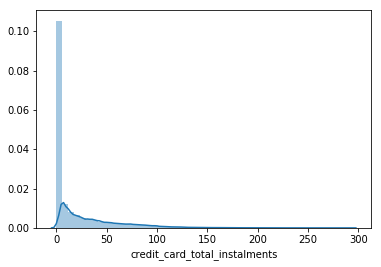

In [12]:
sns.distplot(features['credit_card_total_instalments'])

# Note
* Maybe adding a is_zero variable makes sense

In [13]:
features['credit_card_installments_per_loan'] = (
    features['credit_card_total_instalments'] / features['credit_card_number_of_loans'])
    
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan
0,378907,1,0.0,0.0
1,363914,1,94.0,94.0
2,371185,1,63.0,63.0
3,337855,1,0.0,0.0
4,126868,1,23.0,23.0


In [14]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['credit_card_max_loading_of_credit_limit'].agg('mean').reset_index()
group_object.rename(index=str, columns={'credit_card_max_loading_of_credit_limit': 'credit_card_avg_loading_of_credit_limit'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit
0,378907,1,0.0,0.0,0.696487
1,363914,1,94.0,94.0,0.202349
2,371185,1,63.0,63.0,0.525000
3,337855,1,0.0,0.0,0.000000
4,126868,1,23.0,23.0,1.043303


In [15]:
group_object = credit_card.groupby(
    by=['SK_ID_CURR'])['SK_DPD'].agg('mean').reset_index()
group_object.rename(index=str, columns={'SK_DPD': 'credit_card_average_of_days_past_due'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due
0,378907,1,0.0,0.0,0.696487,0.127660
1,363914,1,94.0,94.0,0.202349,0.010417
2,371185,1,63.0,63.0,0.525000,0.000000
3,337855,1,0.0,0.0,0.000000,0.000000
4,126868,1,23.0,23.0,1.043303,0.010417


In [16]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_DRAWINGS_ATM_CURRENT': 'credit_card_drawings_atm'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due,credit_card_drawings_atm
0,378907,1,0.0,0.0,0.696487,0.127660,67500.0
1,363914,1,94.0,94.0,0.202349,0.010417,293850.0
2,371185,1,63.0,63.0,0.525000,0.000000,506250.0
3,337855,1,0.0,0.0,0.000000,0.000000,50850.0
4,126868,1,23.0,23.0,1.043303,0.010417,763650.0


In [17]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_DRAWINGS_CURRENT': 'credit_card_drawings_total'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due,credit_card_drawings_atm,credit_card_drawings_total
0,378907,1,0.0,0.0,0.696487,0.127660,67500.0,124941.645
1,363914,1,94.0,94.0,0.202349,0.010417,293850.0,358313.670
2,371185,1,63.0,63.0,0.525000,0.000000,506250.0,699566.715
3,337855,1,0.0,0.0,0.000000,0.000000,50850.0,259850.835
4,126868,1,23.0,23.0,1.043303,0.010417,763650.0,1372493.385


In [18]:
features['credit_card_cash_card_ratio'] = features['credit_card_drawings_atm'] / features['credit_card_drawings_total']

features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due,credit_card_drawings_atm,credit_card_drawings_total,credit_card_cash_card_ratio
0,378907,1,0.0,0.0,0.696487,0.127660,67500.0,124941.645,0.540252
1,363914,1,94.0,94.0,0.202349,0.010417,293850.0,358313.670,0.820092
2,371185,1,63.0,63.0,0.525000,0.000000,506250.0,699566.715,0.723662
3,337855,1,0.0,0.0,0.000000,0.000000,50850.0,259850.835,0.195689
4,126868,1,23.0,23.0,1.043303,0.010417,763650.0,1372493.385,0.556396


In [19]:
credit_ONE = features[features['SK_ID_CURR']==215354]

In [20]:
credit_ONE

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due,credit_card_drawings_atm,credit_card_drawings_total,credit_card_cash_card_ratio
76080,215354,1,0.0,0.0,NaN,0.0,1619100.0,1931730.795,0.83816


In [21]:
application = application.merge(features,
                                left_on=['SK_ID_CURR'],
                                right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')

In [22]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
credit_eng = application[engineered_numerical_columns + ['TARGET']]
credit_eng_corr = abs(credit_eng.corr())

In [23]:
credit_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                     1.000000
credit_card_drawings_atm                   0.038106
credit_card_installments_per_loan          0.031622
credit_card_total_instalments              0.031304
credit_card_drawings_total                 0.023680
credit_card_number_of_loans                0.004388
credit_card_average_of_days_past_due       0.003195
credit_card_avg_loading_of_credit_limit    0.002944
credit_card_cash_card_ratio                0.002414
Name: TARGET, dtype: float64

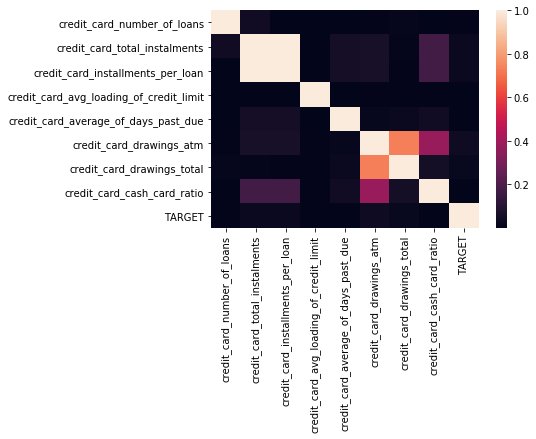

In [24]:
sns.heatmap(credit_eng_corr, 
            xticklabels=credit_eng_corr.columns,
            yticklabels=credit_eng_corr.columns)

## Aggregations

In [25]:
CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_BALANCE',
                   'AMT_CREDIT_LIMIT_ACTUAL',
                   'AMT_DRAWINGS_ATM_CURRENT',
                   'AMT_DRAWINGS_CURRENT',
                   'AMT_DRAWINGS_OTHER_CURRENT',
                   'AMT_DRAWINGS_POS_CURRENT',
                   'AMT_PAYMENT_CURRENT',
                   'CNT_DRAWINGS_ATM_CURRENT',
                   'CNT_DRAWINGS_CURRENT',
                   'CNT_DRAWINGS_OTHER_CURRENT',
                   'CNT_INSTALMENT_MATURE_CUM',
                   'MONTHS_BALANCE',
                   'SK_DPD',
                   'SK_DPD_DEF'
                   ]:
        CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES.append((select, agg))
CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES)]

In [26]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES):
    group_object = credit_card.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [27]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_var_AMT_DRAWINGS_OTHER_CURRENT,SK_ID_CURR_var_AMT_DRAWINGS_POS_CURRENT,SK_ID_CURR_var_AMT_PAYMENT_CURRENT,SK_ID_CURR_var_CNT_DRAWINGS_ATM_CURRENT,SK_ID_CURR_var_CNT_DRAWINGS_CURRENT,SK_ID_CURR_var_CNT_DRAWINGS_OTHER_CURRENT,SK_ID_CURR_var_CNT_INSTALMENT_MATURE_CUM,SK_ID_CURR_var_MONTHS_BALANCE,SK_ID_CURR_var_SK_DPD,SK_ID_CURR_var_SK_DPD_DEF
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,3.5,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [ ]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

# Solution 4
## Hand Crafted Features

In [ ]:
# group = bureau[bureau['bureau_credit_enddate_binary'] == 1].groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT_ENDDATE'], ascending=True)).reset_index(drop=True)
# group['bureau_days_enddate_diff'] = group.groupby(by=['SK_ID_CURR'])['DAYS_CREDIT_ENDDATE'].diff()
# group['bureau_days_enddate_diff'] = group['bureau_days_enddate_diff'].fillna(0).astype('uint32')

# bureau = bureau.merge(group[['bureau_days_enddate_diff', 'SK_ID_BUREAU']], on=['SK_ID_BUREAU'], how='left')
# bureau['bureau_average_enddate_future'] = bureau.groupby(
#     by=['SK_ID_CURR'])['bureau_days_enddate_diff'].agg('mean').reset_index()['bureau_days_enddate_diff']

# bureau['bureau_days_credit_diff'] = bureau.groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT'], ascending=False)).reset_index(drop=True)['DAYS_CREDIT']
# bureau['bureau_days_credit_diff'] *= -1
# bureau['bureau_days_credit_diff'] = bureau.groupby(by=['SK_ID_CURR'])['bureau_days_credit_diff'].diff()
# bureau['bureau_days_credit_diff'] = bureau['bureau_days_credit_diff'].fillna(0)

In [ ]:
# credit_card_sorted = credit_card.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
# credit_card_sorted['credit_card_monthly_diff'] = credit_card_sorted.groupby(
#     by='SK_ID_CURR')['AMT_BALANCE'].diff()
# group_object = credit_card_sorted.groupby(['SK_ID_CURR'])['credit_card_monthly_diff'].agg('mean').reset_index()
# group_object.rename(index=str,
#                     columns={'credit_card_monthly_diff': 'credit_card_monthly_diff_mean'},
#                     inplace=True)

# features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
# features.head()